# Vanilla GAN with FashionMNIST

### Lab Overview

<img src='../Figures/Lab1_overview.png'/>

### Prerequisite

In [1]:
import torch 
import os

# mps setting
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"{device} is available.")

mps is available.


In [2]:
# save model
model_dir = os.path.join('result/1/model')
os.makedirs(model_dir, exist_ok=True)

image_dir = os.path.join('result/1/sample')
os.makedirs(image_dir, exist_ok=True)

loss_dir = os.path.join('result/1/loss')
os.makedirs(loss_dir, exist_ok=True)

### Import Libraries

In [3]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os

### Datasets

In [4]:
training_data = datasets.FashionMNIST(
    root='data/target/1',
    train=True,
    download=False,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

test_data = datasets.FashionMNIST(
    root='data/target/1',
    train=False,
    download=False,
    transform=ToTensor()
)

### Hyperparameters

In [5]:
NOISE = 100
INPUT_SIZE = 28 * 28
BATCH_SIZE = 64
EPOCHS = 50

### Generator

In [6]:
class Generator(nn.Module):
    def __init__(self, noise):
        super(Generator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(noise, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )
    
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)  # reshape to (batch_size, 1, 28, 28)
        return img

### Discriminator

In [7]:
class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.model(x)
        return x

### Configurate Model

In [8]:
generator = Generator(NOISE).to(device)
print(f"Generate is using {device}.")
print(generator)

Generate is using mps.
Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)


In [9]:
discriminator = Discriminator(INPUT_SIZE).to(device)
print(f"Discriminator is using {device}")
print(discriminator)

Discriminator is using mps
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=128, bias=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=128, out_features=1, bias=True)
    (13): Sigmoid()
  )
)


In [10]:
criterion = nn.BCELoss()
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=1e-4)
optimizer_generator = optim.Adam(generator.parameters(), lr=1e-4)

In [11]:
for param in discriminator.parameters():
    param.requires_grad = False

In [12]:
gan_input = torch.randn(BATCH_SIZE, NOISE).to(device)
x = generator(gan_input)
output = discriminator(x)

In [13]:
train_loader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)

In [17]:
def visualize_training(epoch, d_losses, g_losses, output_dir='result/sample', loss_dir='result/loss'):
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(loss_dir, exist_ok=True)

    plt.figure(figsize=(8, 4))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generatror Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    plt.title('epoch: {}, Discriminator Loss: {}, Generator Loss: {}'.format(epoch, np.asarray(d_losses).mean(), np.asarray(g_losses).mean()))
    plt.savefig(os.path.join(loss_dir, f'generated_images_epoch_{epoch}.png'))
    plt.close()
    
    print('epoch: {}, Discriminator Loss: {}, Generator Loss: {}'.format(epoch, np.asarray(d_losses).mean(), np.asarray(g_losses).mean()))
    
    #Visualize after creating sample data
    noise = torch.randn(24, NOISE).to(device)
    generated_images = generator(noise).cpu().detach().numpy()
    generated_images = generated_images.reshape(-1, 28, 28)
    
    plt.figure(figsize=(8, 4))
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 6, i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'generated_images_epoch_{epoch}.png'))
    plt.close()
    plt.show()

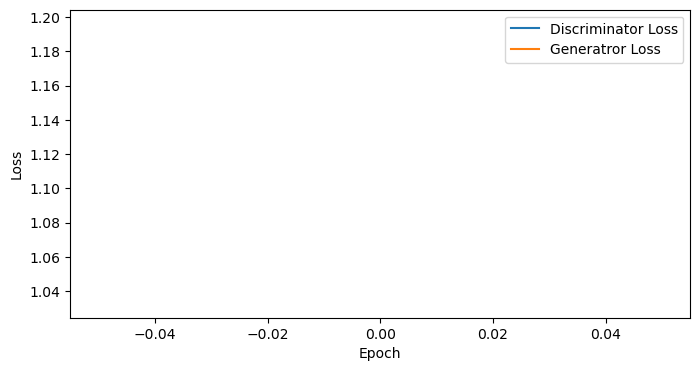

epoch: 0, Discriminator Loss: 1.032695084810257, Generator Loss: 1.1961077451705933


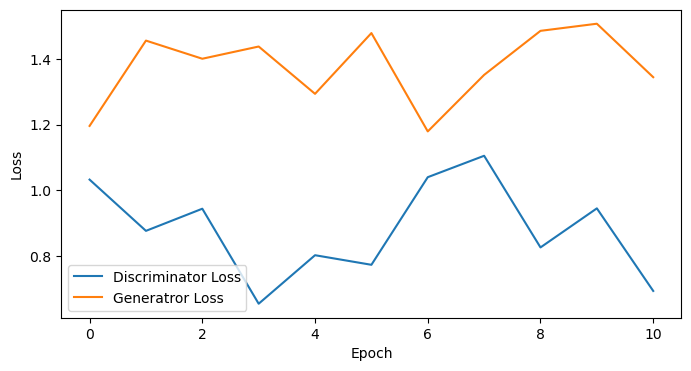

epoch: 10, Discriminator Loss: 0.8813771497119557, Generator Loss: 1.375522342595187


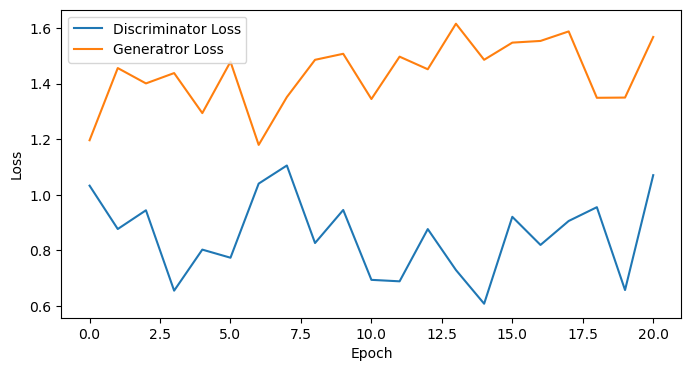

epoch: 20, Discriminator Loss: 0.853614900793348, Generator Loss: 1.4349851097379411


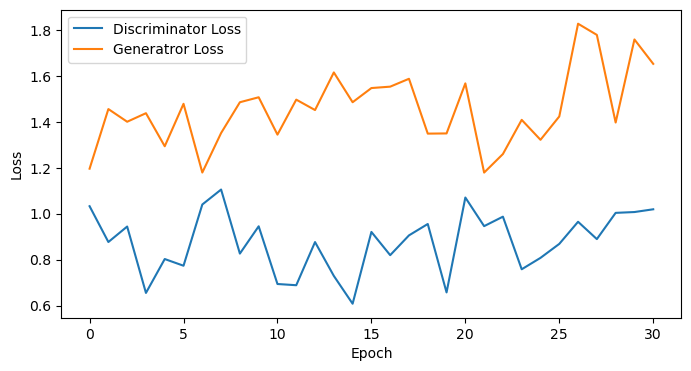

epoch: 30, Discriminator Loss: 0.8766960405534313, Generator Loss: 1.4562396580173123


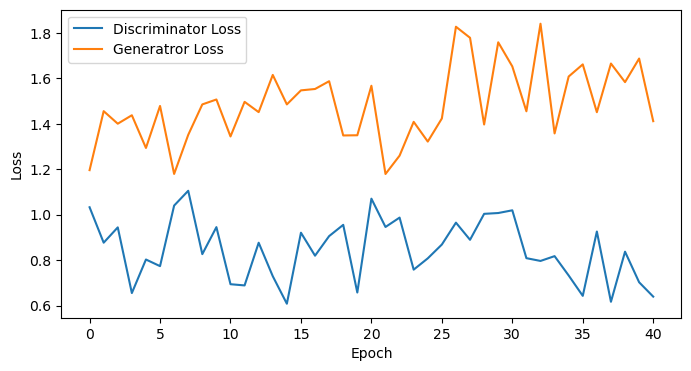

epoch: 40, Discriminator Loss: 0.8462361097335815, Generator Loss: 1.484557108181279


In [19]:
d_losses = []
g_losses = []

for epoch in range(EPOCHS):
    for i, (real_images, _) in enumerate(train_loader):

        batch_size = real_images.size(0)
        real_images = real_images.view(batch_size, -1).to(device)

        # Real and fake labels
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator
        for param in discriminator.parameters():
            param.requires_grad = True

        optimizer_discriminator.zero_grad()

        outputs = discriminator(real_images)
        d_loss_real = criterion(outputs, real_labels)
        d_loss_real.backward()

        z = torch.randn(batch_size, NOISE).to(device)

        fake_images = generator(z)
        outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        d_loss_fake.backward()

        optimizer_discriminator.step()

        # Train Generator
        for param in discriminator.parameters():
            param.requires_grad = False
        
        optimizer_generator.zero_grad()

        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()

        optimizer_generator.step()
    
    d_losses.append(d_loss_real.item() + d_loss_fake.item())
    g_losses.append(g_loss.item())

    if epoch % 10 == 0:
        visualize_training(epoch, d_losses, g_losses)
        torch.save(generator.state_dict(), os.path.join(model_dir, f'generator.pth'))
        torch.save(discriminator.state_dict(), os.path.join(model_dir, f'discriminator.pth'))